In [2]:
import h5py
import astropy
import astropy.units as u 
import astropy.coordinates as coord
import astropy.time as at
import astropy.constants as const
import numpy as np

import sys 

sys.path.insert(0,'..')
import jabble.dataset
import jabble.loss
import jabble.model

import pickle

In [3]:
sys.path.insert(0,'../../WobbleSim')
import simulacra.dataset

In [4]:
print(jabble.dataset.velocities(9e-3)/const.c)

0.00899975700787291


<h1>10 - Same Training Cyle with many different datasets</h1>
Instead of fitting to one dataset, we will now fit to multiple datasets with varying levels of SNR.

In [5]:
import os

In [6]:
indir = '/scratch/mdd423/simulacra/out/2021-11-01/'
filenames = [os.path.join(indir, file) for file in os.listdir(indir) if file.startswith('data_e30')]
# filenames = ['data_e45_R70000.0_a2000.0_p40.3_l7.0e+039.0e+03_ep1.0_w0.0_snr1.2e+00.h5']
outdir = '/scratch/mdd423/wobble_jax/out/'

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/mdd423/simulacra/out/2021-11-01/'

In [7]:
print(len(filenames))

NameError: name 'filenames' is not defined

<h2>Simulacra Datasets</h2>
Initizialize multiple datasets from simulacra that each with different levels of SNR.

In [7]:
import scipy.ndimage
def normalize(y,sigma):
    y_low = scipy.ndimage.gaussian_filter(y,sigma)
    return y/y_low

In [8]:
datasets = []
timess   = []
bcs      = []
rvs      = []
periods  = []
snrs     = []

for filename in filenames:
    data    = simulacra.dataset.from_h5(filename)
    epoches = data['data']['flux'].shape[0]

    masks = np.array(data['data']['mask'],dtype=bool)
    wave = np.repeat(np.array(data['data']['wave'])[np.newaxis,:],epoches,axis=0) * u.Angstrom
    flux = np.array(data['data']['flux'])
    ferr = np.array(data['data']['ferr'])
    print(np.where(np.isnan(ferr)))
    print(np.where(masks))
    masks = np.isnan(ferr)
    
    sigma = 80
    wob_data = jabble.dataset.WobbleDataset(wave,flux,ferr,masks,normalize,nargs=[sigma])
    wob_data.set_masks(0.0,10.0)
    datasets.append(wob_data)
    obs_times = data['data']['obs_times']
    exp_times = data['data']['exp_times']
    timess.append(at.Time(obs_times + exp_times/2))
    
    loc    = data['parameters']['detector']['loc']
    target = data['parameters']['star']['target']
    resolution = float(data['parameters']['detector']['resolution'][()])
    
    periods.append(data['parameters']['star']['period'])
    bcs.append(target.radial_velocity_correction(obstime=timess[-1],location=loc).to(u.km/u.s))
    rvs.append(data['data']['rvs'].to(u.km/u.s))
    snrs.append(np.mean(data['data']['snr_readout'][~np.isnan(data['data']['snr_readout'])]))

<HDF5 dataset "obs_times": shape (30,), type "|O">
(array([ 0,  0,  0, ..., 29, 29, 29]), array([   24,    25,   121, ..., 34852, 34857, 34984]))
(array([], dtype=int64), array([], dtype=int64))


../jabble/dataset.py:130: RuntimeWarning: divide by zero encountered in log
  self.xs, self.ys, self.yerr = np.log(wave.to(u.Angstrom).value), np.log(flux_norm), flux_error/flux


<HDF5 dataset "obs_times": shape (30,), type "|O">
(array([ 0,  0,  0, ..., 29, 29, 29]), array([ 3106,  3107,  3110, ..., 12830, 12849, 12850]))
(array([], dtype=int64), array([], dtype=int64))
<HDF5 dataset "obs_times": shape (30,), type "|O">
(array([ 0,  0,  0, ..., 29, 29, 29]), array([ 3101,  3105,  3115, ..., 12737, 12832, 12851]))
(array([], dtype=int64), array([], dtype=int64))
<HDF5 dataset "obs_times": shape (30,), type "|O">
(array([ 0,  0,  0, ..., 29, 29, 29]), array([ 3102,  3104,  3109, ..., 12966, 22437, 27700]))
(array([], dtype=int64), array([], dtype=int64))
<HDF5 dataset "obs_times": shape (30,), type "|O">
(array([ 0,  0,  0, ..., 29, 29, 29]), array([  131,   346,   349, ..., 34858, 34859, 34861]))
(array([], dtype=int64), array([], dtype=int64))
<HDF5 dataset "obs_times": shape (30,), type "|O">
(array([ 0,  0,  0, ..., 29, 29, 29]), array([   29,   116,   124, ..., 34858, 34863, 34864]))
(array([], dtype=int64), array([], dtype=int64))
<HDF5 dataset "obs_times"

In [9]:
timess[0] == timess[1]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True])

<h2>Check the Velocities</h2>
Here we are plotting the theoretical velocities we will be fitting for with Jabble. Just to make sure they make sense. And if our location and target are in the right positions.

In [10]:
import matplotlib.pyplot as plt
from matplotlib import cm

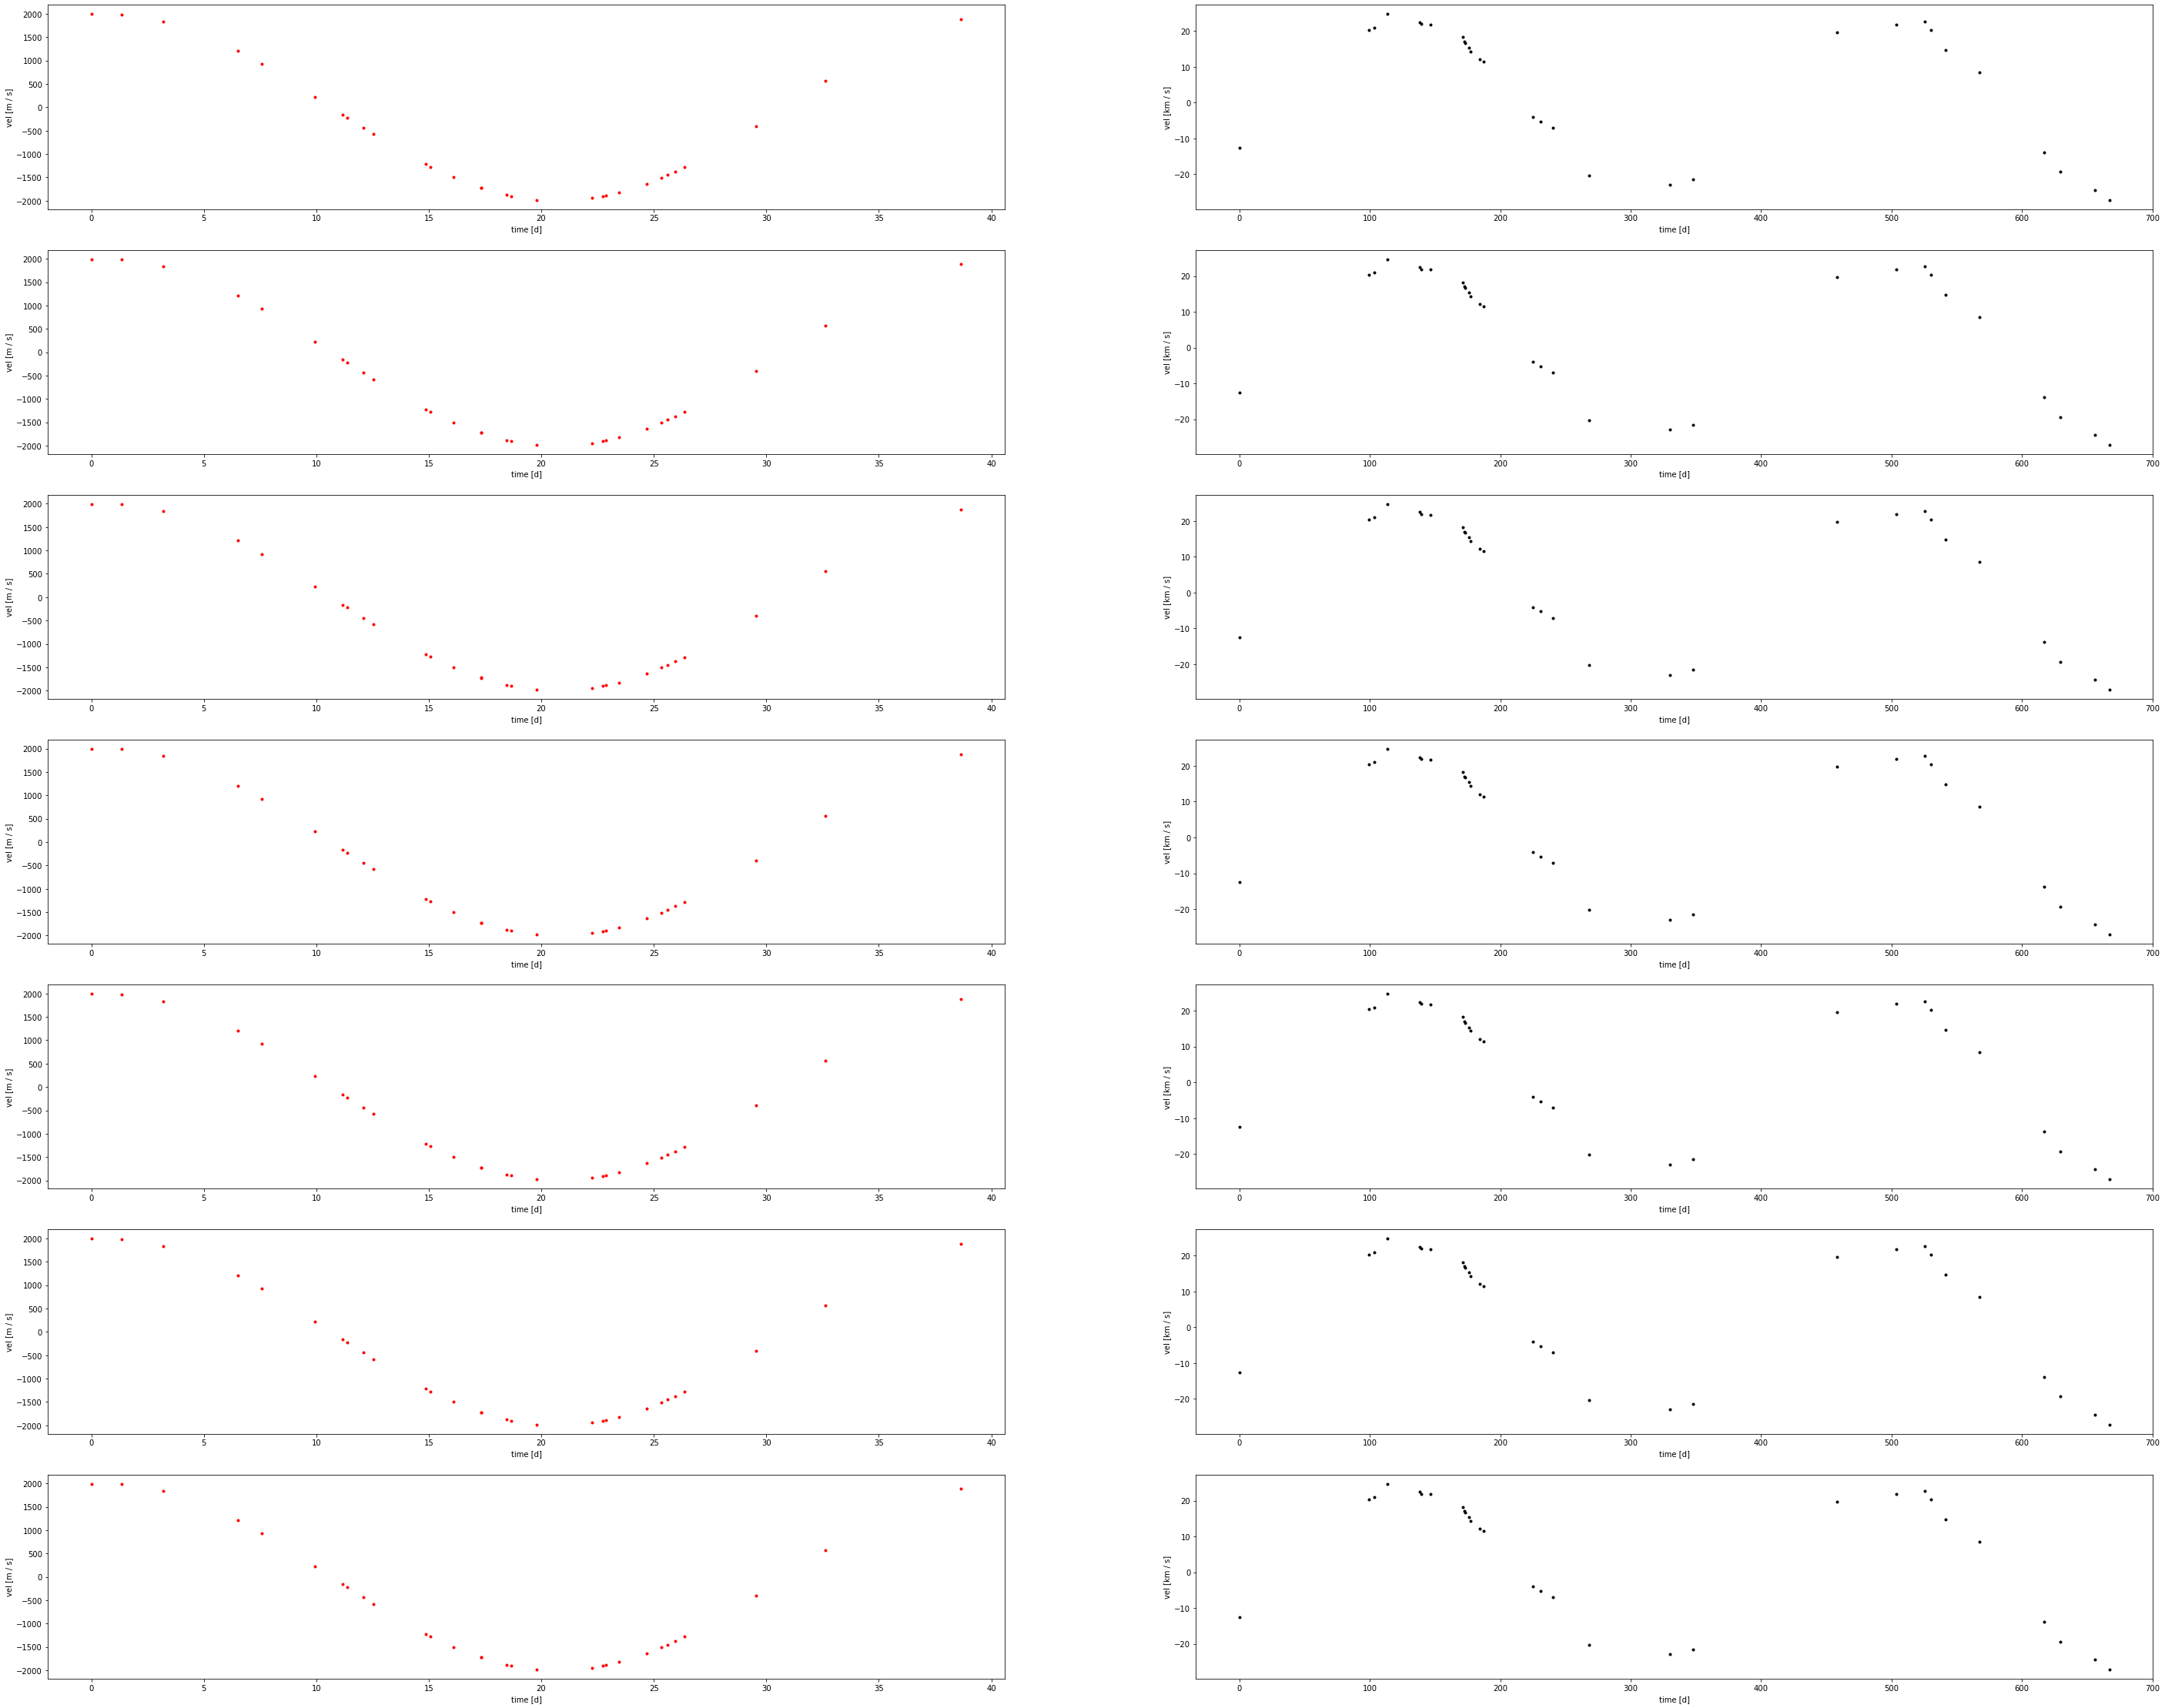

In [11]:
fig, axes = plt.subplots(len(datasets),2,figsize=(7 * len(datasets),40))
for i,data in enumerate(datasets):
    eprv = rvs[i] - bcs[i]
    
    v_unit = u.m/u.s
    axes[i,0].plot((timess[i] - min(timess[i])).to(u.day).value % periods[i].to(u.day).value,eprv.to(v_unit).value,'.r')
    axes[i,0].set_ylabel('vel [{}]'.format(v_unit))
    axes[i,0].set_xlabel('time [d]')

    v_unit = u.km/u.s
    axes[i,1].plot((timess[i] - min(timess[i])).to(u.day).value,rvs[i].to(v_unit).value,'.k')
    axes[i,1].set_ylabel('vel [{}]'.format(v_unit))
    axes[i,1].set_xlabel('time [d]')
plt.show()

<h2>Loss Function</h2>
Define the loss function from the jabble.loss module. If the errorbars are too bad, use the L2Loss function.

In [12]:
loss = jabble.loss.ChiSquare()

<h2>Create a set of Models</h2>
Here we are going to create of list of models. One per each dataset by copying the stellar_model.

In [13]:
vel_padding = 100 * u.km/u.s

Now we will only be fitting the linear model first, which is at the position 1 in the list in the CompositeModel

In [14]:
init_shifts = jabble.dataset.shifts(bcs[i])

In [15]:
x_grid = jabble.model.create_x_grid(datasets[0].xs,vel_padding,resolution)#step=jabble.dataset.shifts(const.c.to(u.km/u.s)/resolution))
stellar_model = jabble.model.CompositeModel([jabble.model.ShiftingModel(init_shifts),jabble.model.JaxLinear(x_grid)])

In [16]:
import copy

In [17]:
models = [copy.deepcopy(stellar_model) for data in datasets]

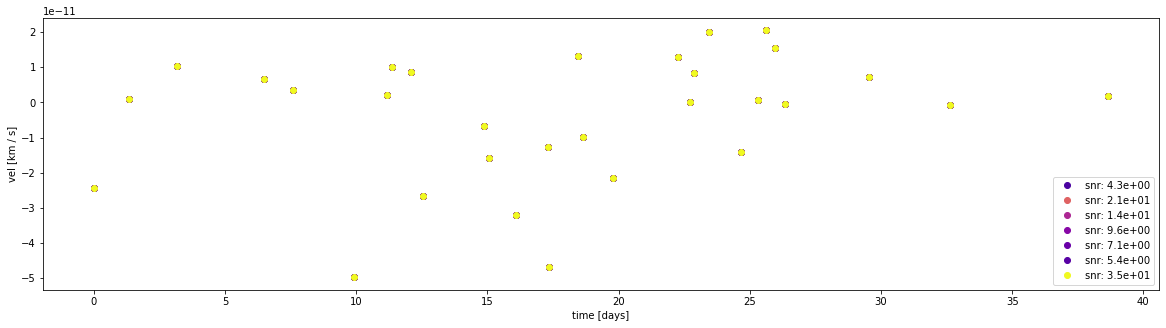

In [18]:
# model_idx = 4
v_unit = u.km/u.s
plt.figure(figsize=(20,5))
for model_idx in range(len(models)):
    init_vels = jabble.dataset.velocities(models[model_idx][0].p)
    plt.plot((timess[model_idx] - min(timess[model_idx])).to(u.day).value % periods[model_idx].value,\
             (init_vels-bcs[model_idx]).to(v_unit).value,'o',label='snr: {:2.1e}'.format(snrs[model_idx]),\
             c=cm.plasma(snrs[model_idx]/max(snrs)))
plt.legend()
plt.ylabel('vel [{}]'.format(v_unit))
plt.xlabel('time [days]')
plt.show()

<h2>Fitting Time</h2>
Now it's time to fit the model to the data using our loss function. And setting some maxiter to stop early to prevent any overfitting.

In [19]:
def train_cycle(model,data,loss,fit1_inds,fit2_inds,maxiter1,maxiter2):
    # Fitting Round 1
    print('fitting round 1')
    model.fix()
    for ind in fit1_inds:
        model.fit(*ind)
    res1 = model.optimize(loss,data,maxiter1)
    model.fix()
    
    # Grid Search
    print('grid searching')
    vel_width = 5 * u.km/u.s
    vel_step = const.c/resolution/10.
    velocity_kern = np.arange(-vel_width.to(u.km/u.s).value,vel_width.to(u.km/u.s).value,vel_step.to(u.km/u.s).value)*u.km/u.s
    velocity_grid = np.add.outer(bcs[i],velocity_kern)
    
    shift_grid = jabble.dataset.shifts(velocity_grid)
    loss_array = model[0].grid_search(shift_grid,loss,model,data)
    
    x_min, x_vals, y_vals, polynomials = jabble.dataset.get_parabolic_min(loss_array,shift_grid,return_all=True)     
    stellar_model[0].p = x_min
    
    # Fitting Round 2
    print('fitting round 2')
    model.fix()
    for ind in fit2_inds:
        model.fit(*ind)
    res2 = model.optimize(loss,data,maxiter2)
    return model

fitting model 0
fitting round 1
[ Value: +3.61e+07 Grad: +1.11e+12 ]
[ Value: +3.51e+07 Grad: +9.60e+11 ]
[ Value: +3.18e+07 Grad: +4.87e+11 ]
[ Value: +2.79e+07 Grad: +1.17e+10 ]
[ Value: +2.77e+07 Grad: +4.39e+09 ]
[ Value: +2.76e+07 Grad: +2.53e+09 ]
[ Value: +2.76e+07 Grad: +2.18e+09 ]
[ Value: +2.76e+07 Grad: +1.02e+09 ]
[ Value: +2.75e+07 Grad: +8.50e+08 ]
[ Value: +2.75e+07 Grad: +1.43e+09 ]
[ Value: +2.75e+07 Grad: +5.85e+08 ]
[ Value: +2.75e+07 Grad: +4.04e+08 ]
[ Value: +2.75e+07 Grad: +6.19e+08 ]
[ Value: +2.75e+07 Grad: +2.04e+08 ]
[ Value: +2.75e+07 Grad: +8.22e+07 ]
[ Value: +2.75e+07 Grad: +8.85e+07 ]
[ Value: +2.75e+07 Grad: +3.59e+07 ]
[ Value: +2.75e+07 Grad: +4.02e+07 ]
[ Value: +2.75e+07 Grad: +1.75e+07 ]
[ Value: +2.75e+07 Grad: +1.28e+07 ]
[ Value: +2.75e+07 Grad: +3.19e+07 ]
[ Value: +2.75e+07 Grad: +8.43e+06 ]
[ Value: +2.75e+07 Grad: +5.64e+06 ]
[ Value: +2.75e+07 Grad: +6.73e+06 ]
[ Value: +2.75e+07 Grad: +2.38e+07 ]
[ Value: +2.75e+07 Grad: +3.30e+06 ]
[ Valu

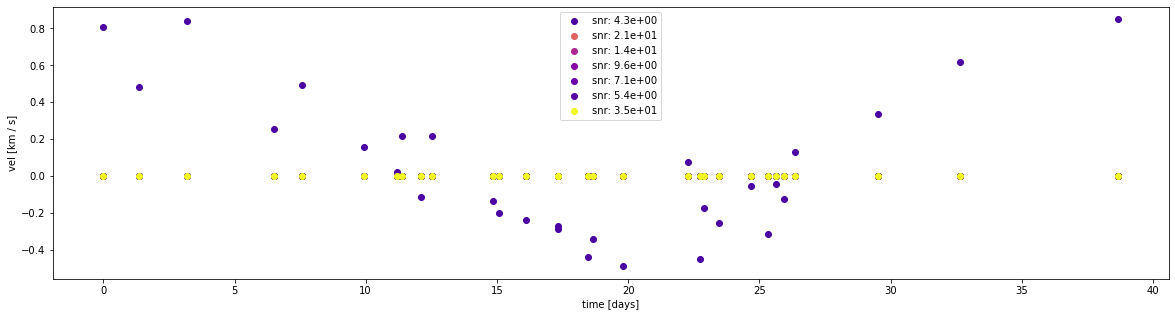

fitting model 1
fitting round 1
[ Value: +2.29e+08 Grad: +2.81e+14 ]
[ Value: +2.13e+08 Grad: +2.37e+14 ]
[ Value: +1.63e+08 Grad: +1.00e+14 ]
[ Value: +1.18e+08 Grad: +4.90e+12 ]
[ Value: +1.15e+08 Grad: +2.11e+12 ]
[ Value: +1.13e+08 Grad: +1.60e+12 ]
[ Value: +1.12e+08 Grad: +8.32e+11 ]
[ Value: +1.12e+08 Grad: +3.07e+11 ]
[ Value: +1.11e+08 Grad: +1.33e+11 ]
[ Value: +1.11e+08 Grad: +1.44e+11 ]
[ Value: +1.11e+08 Grad: +7.80e+10 ]
[ Value: +1.11e+08 Grad: +4.97e+10 ]
[ Value: +1.11e+08 Grad: +3.36e+10 ]
[ Value: +1.11e+08 Grad: +4.08e+10 ]
[ Value: +1.11e+08 Grad: +7.55e+10 ]
[ Value: +1.11e+08 Grad: +1.42e+10 ]
[ Value: +1.11e+08 Grad: +1.09e+10 ]
[ Value: +1.11e+08 Grad: +1.42e+10 ]
[ Value: +1.11e+08 Grad: +8.99e+10 ]
[ Value: +1.11e+08 Grad: +9.31e+09 ]
[ Value: +1.11e+08 Grad: +5.17e+09 ]
[ Value: +1.11e+08 Grad: +8.01e+09 ]
[ Value: +1.11e+08 Grad: +1.37e+10 ]
[ Value: +1.11e+08 Grad: +3.18e+10 ]
[ Value: +1.11e+08 Grad: +5.39e+09 ]
[ Value: +1.11e+08 Grad: +6.30e+09 ]
[ Valu

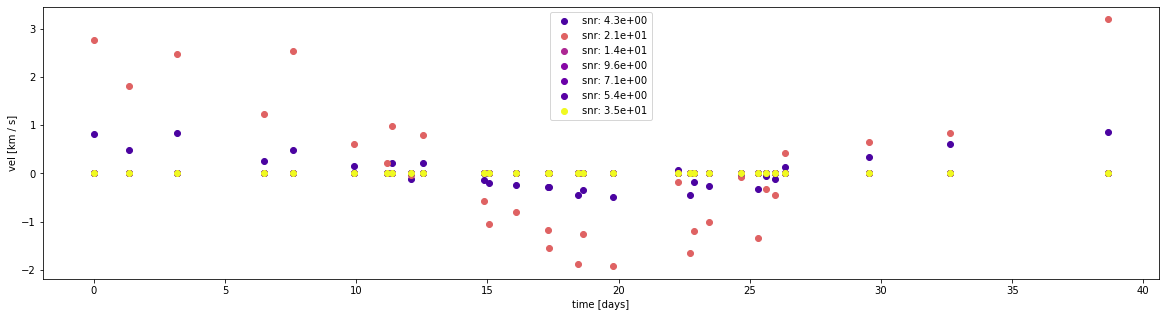

fitting model 2
fitting round 1
[ Value: +1.11e+08 Grad: +5.28e+13 ]
[ Value: +1.04e+08 Grad: +4.43e+13 ]
[ Value: +8.21e+07 Grad: +1.84e+13 ]
[ Value: +6.35e+07 Grad: +9.07e+11 ]
[ Value: +6.23e+07 Grad: +3.93e+11 ]
[ Value: +6.14e+07 Grad: +2.46e+11 ]
[ Value: +6.11e+07 Grad: +1.37e+11 ]
[ Value: +6.09e+07 Grad: +5.58e+10 ]
[ Value: +6.08e+07 Grad: +2.96e+10 ]
[ Value: +6.07e+07 Grad: +3.61e+10 ]
[ Value: +6.07e+07 Grad: +1.26e+10 ]
[ Value: +6.06e+07 Grad: +9.34e+09 ]
[ Value: +6.06e+07 Grad: +9.33e+09 ]
[ Value: +6.06e+07 Grad: +6.84e+09 ]
[ Value: +6.06e+07 Grad: +1.06e+10 ]
[ Value: +6.06e+07 Grad: +4.05e+09 ]
[ Value: +6.05e+07 Grad: +3.68e+09 ]
[ Value: +6.05e+07 Grad: +6.37e+09 ]
[ Value: +6.05e+07 Grad: +7.09e+09 ]
[ Value: +6.05e+07 Grad: +2.66e+09 ]
[ Value: +6.05e+07 Grad: +2.73e+09 ]
[ Value: +6.05e+07 Grad: +4.19e+09 ]
[ Value: +6.05e+07 Grad: +6.31e+09 ]
[ Value: +6.05e+07 Grad: +2.95e+09 ]
[ Value: +6.05e+07 Grad: +2.52e+09 ]
[ Value: +6.05e+07 Grad: +3.66e+09 ]
[ Valu

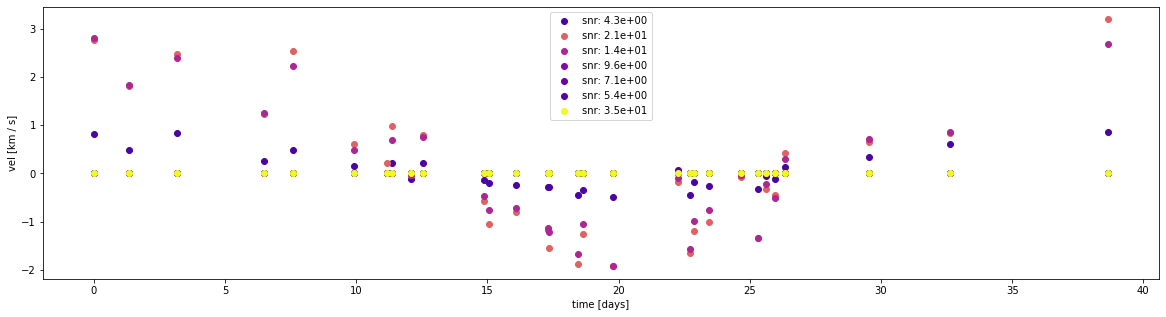

fitting model 3
fitting round 1
[ Value: +6.80e+07 Grad: +1.36e+13 ]
[ Value: +6.45e+07 Grad: +1.14e+13 ]
[ Value: +5.35e+07 Grad: +4.75e+12 ]
[ Value: +4.41e+07 Grad: +2.25e+11 ]
[ Value: +4.34e+07 Grad: +9.68e+10 ]
[ Value: +4.30e+07 Grad: +5.12e+10 ]
[ Value: +4.29e+07 Grad: +3.12e+10 ]
[ Value: +4.28e+07 Grad: +1.31e+10 ]
[ Value: +4.27e+07 Grad: +8.38e+09 ]
[ Value: +4.27e+07 Grad: +9.83e+09 ]
[ Value: +4.27e+07 Grad: +3.76e+09 ]
[ Value: +4.26e+07 Grad: +2.75e+09 ]
[ Value: +4.26e+07 Grad: +3.37e+09 ]
[ Value: +4.26e+07 Grad: +3.07e+09 ]
[ Value: +4.26e+07 Grad: +3.61e+09 ]
[ Value: +4.26e+07 Grad: +1.73e+09 ]
[ Value: +4.26e+07 Grad: +1.69e+09 ]
[ Value: +4.26e+07 Grad: +3.17e+09 ]
[ Value: +4.25e+07 Grad: +1.37e+09 ]
[ Value: +4.25e+07 Grad: +1.22e+09 ]
[ Value: +4.25e+07 Grad: +1.85e+09 ]
[ Value: +4.25e+07 Grad: +1.04e+09 ]
[ Value: +4.25e+07 Grad: +9.99e+08 ]
[ Value: +4.25e+07 Grad: +9.15e+08 ]
[ Value: +4.25e+07 Grad: +5.48e+08 ]
[ Value: +4.25e+07 Grad: +7.29e+08 ]
[ Valu

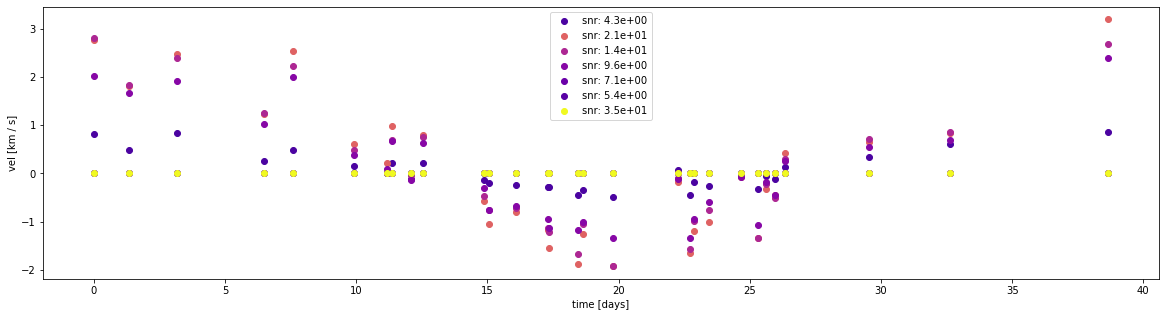

fitting model 4
fitting round 1
[ Value: +4.98e+07 Grad: +4.56e+12 ]
[ Value: +4.78e+07 Grad: +3.84e+12 ]
[ Value: +4.13e+07 Grad: +1.64e+12 ]
[ Value: +3.57e+07 Grad: +6.82e+10 ]
[ Value: +3.53e+07 Grad: +2.80e+10 ]
[ Value: +3.51e+07 Grad: +1.40e+10 ]
[ Value: +3.51e+07 Grad: +9.10e+09 ]
[ Value: +3.50e+07 Grad: +3.97e+09 ]
[ Value: +3.50e+07 Grad: +2.98e+09 ]
[ Value: +3.49e+07 Grad: +3.59e+09 ]
[ Value: +3.49e+07 Grad: +1.61e+09 ]
[ Value: +3.49e+07 Grad: +1.37e+09 ]
[ Value: +3.49e+07 Grad: +1.72e+09 ]
[ Value: +3.49e+07 Grad: +1.28e+09 ]
[ Value: +3.49e+07 Grad: +1.99e+09 ]
[ Value: +3.49e+07 Grad: +8.40e+08 ]
[ Value: +3.49e+07 Grad: +6.53e+08 ]
[ Value: +3.48e+07 Grad: +1.04e+09 ]
[ Value: +3.48e+07 Grad: +8.60e+08 ]
[ Value: +3.48e+07 Grad: +3.20e+08 ]
[ Value: +3.48e+07 Grad: +2.31e+08 ]
[ Value: +3.48e+07 Grad: +3.93e+08 ]
[ Value: +3.48e+07 Grad: +1.52e+08 ]
[ Value: +3.48e+07 Grad: +1.31e+08 ]
[ Value: +3.48e+07 Grad: +8.46e+07 ]
[ Value: +3.48e+07 Grad: +5.84e+07 ]
[ Valu

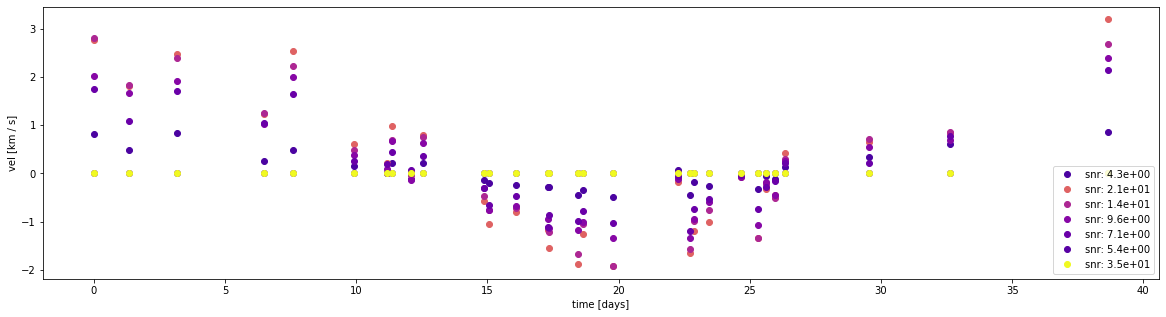

fitting model 5
fitting round 1
[ Value: +4.10e+07 Grad: +2.01e+12 ]
[ Value: +3.96e+07 Grad: +1.71e+12 ]
[ Value: +3.53e+07 Grad: +7.81e+11 ]
[ Value: +3.10e+07 Grad: +2.58e+10 ]
[ Value: +3.08e+07 Grad: +1.01e+10 ]
[ Value: +3.07e+07 Grad: +5.50e+09 ]
[ Value: +3.06e+07 Grad: +3.90e+09 ]
[ Value: +3.06e+07 Grad: +1.78e+09 ]
[ Value: +3.05e+07 Grad: +1.49e+09 ]
[ Value: +3.05e+07 Grad: +2.10e+09 ]
[ Value: +3.05e+07 Grad: +9.20e+08 ]
[ Value: +3.05e+07 Grad: +7.51e+08 ]
[ Value: +3.05e+07 Grad: +1.09e+09 ]
[ Value: +3.05e+07 Grad: +6.31e+08 ]
[ Value: +3.05e+07 Grad: +1.31e+09 ]
[ Value: +3.05e+07 Grad: +3.39e+08 ]
[ Value: +3.05e+07 Grad: +1.59e+08 ]
[ Value: +3.05e+07 Grad: +1.20e+08 ]
[ Value: +3.05e+07 Grad: +3.30e+08 ]
[ Value: +3.04e+07 Grad: +7.10e+07 ]
[ Value: +3.04e+07 Grad: +3.46e+07 ]
[ Value: +3.04e+07 Grad: +3.76e+07 ]
[ Value: +3.04e+07 Grad: +6.06e+07 ]
[ Value: +3.04e+07 Grad: +2.13e+08 ]
[ Value: +3.04e+07 Grad: +2.91e+07 ]
[ Value: +3.04e+07 Grad: +1.07e+07 ]
[ Valu

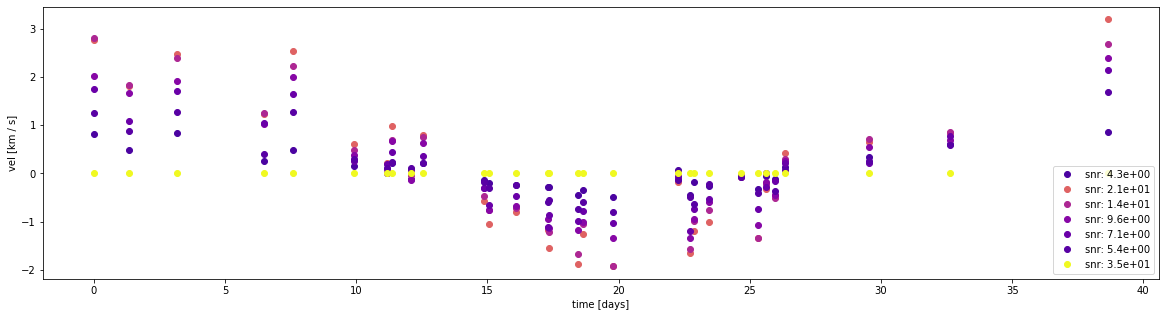

fitting model 6
fitting round 1
[ Value: +6.59e+08 Grad: +2.39e+15 ]
[ Value: +6.12e+08 Grad: +2.02e+15 ]
[ Value: +4.64e+08 Grad: +8.86e+14 ]
[ Value: +3.25e+08 Grad: +4.19e+13 ]
[ Value: +3.16e+08 Grad: +1.80e+13 ]
[ Value: +3.09e+08 Grad: +1.55e+13 ]
[ Value: +3.07e+08 Grad: +8.45e+12 ]
[ Value: +3.06e+08 Grad: +2.37e+12 ]
[ Value: +3.05e+08 Grad: +9.29e+11 ]
[ Value: +3.04e+08 Grad: +7.91e+11 ]
[ Value: +3.04e+08 Grad: +5.98e+12 ]
[ Value: +3.04e+08 Grad: +1.68e+12 ]
[ Value: +3.04e+08 Grad: +2.95e+11 ]
[ Value: +3.04e+08 Grad: +2.03e+11 ]
[ Value: +3.04e+08 Grad: +4.36e+11 ]
[ Value: +3.04e+08 Grad: +4.93e+11 ]
[ Value: +3.03e+08 Grad: +1.20e+11 ]
[ Value: +3.03e+08 Grad: +7.60e+10 ]
[ Value: +3.03e+08 Grad: +9.26e+10 ]
[ Value: +3.03e+08 Grad: +5.28e+11 ]
[ Value: +3.03e+08 Grad: +5.07e+10 ]
[ Value: +3.03e+08 Grad: +3.37e+10 ]
[ Value: +3.03e+08 Grad: +5.47e+10 ]
[ Value: +3.03e+08 Grad: +1.99e+11 ]
[ Value: +3.03e+08 Grad: +5.45e+10 ]
[ Value: +3.03e+08 Grad: +3.18e+10 ]
[ Valu

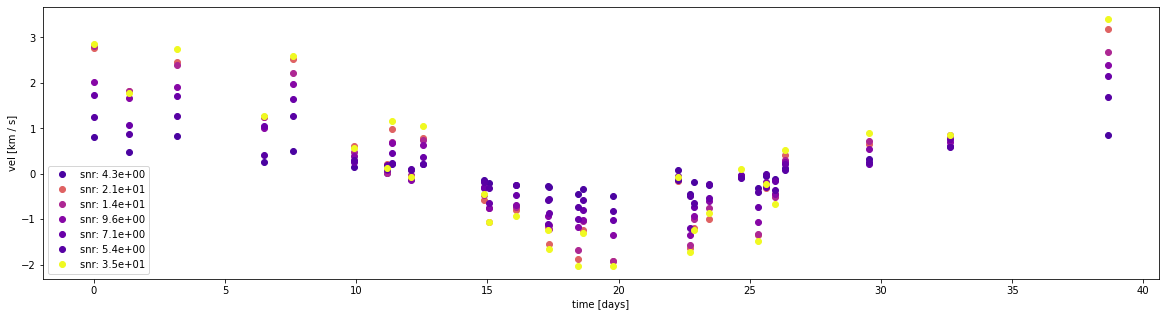

In [20]:
for i,model in enumerate(models):
    print('fitting model {}'.format(i))
    model = train_cycle(model,datasets[i],loss,[[1]],[[1],[0]],256,512)
    v_unit = u.km/u.s
    plt.figure(figsize=(20,5))
    for model_idx in range(len(models)):
        init_vels = jabble.dataset.velocities(models[model_idx][0].p)
        plt.plot((timess[model_idx] - min(timess[model_idx])).to(u.day).value % periods[model_idx].value,\
                 (init_vels-bcs[model_idx]).to(v_unit).value,'o',label='snr: {:2.1e}'.format(snrs[model_idx]),\
                 c=cm.plasma(snrs[model_idx]/max(snrs)))
    plt.legend()
    plt.ylabel('vel [{}]'.format(v_unit))
    plt.xlabel('time [days]')
    plt.show()

In [21]:
for model in models:
    print(np.sum(models[0][1].p == model[1].p))

17539
33
33
33
33
33
33


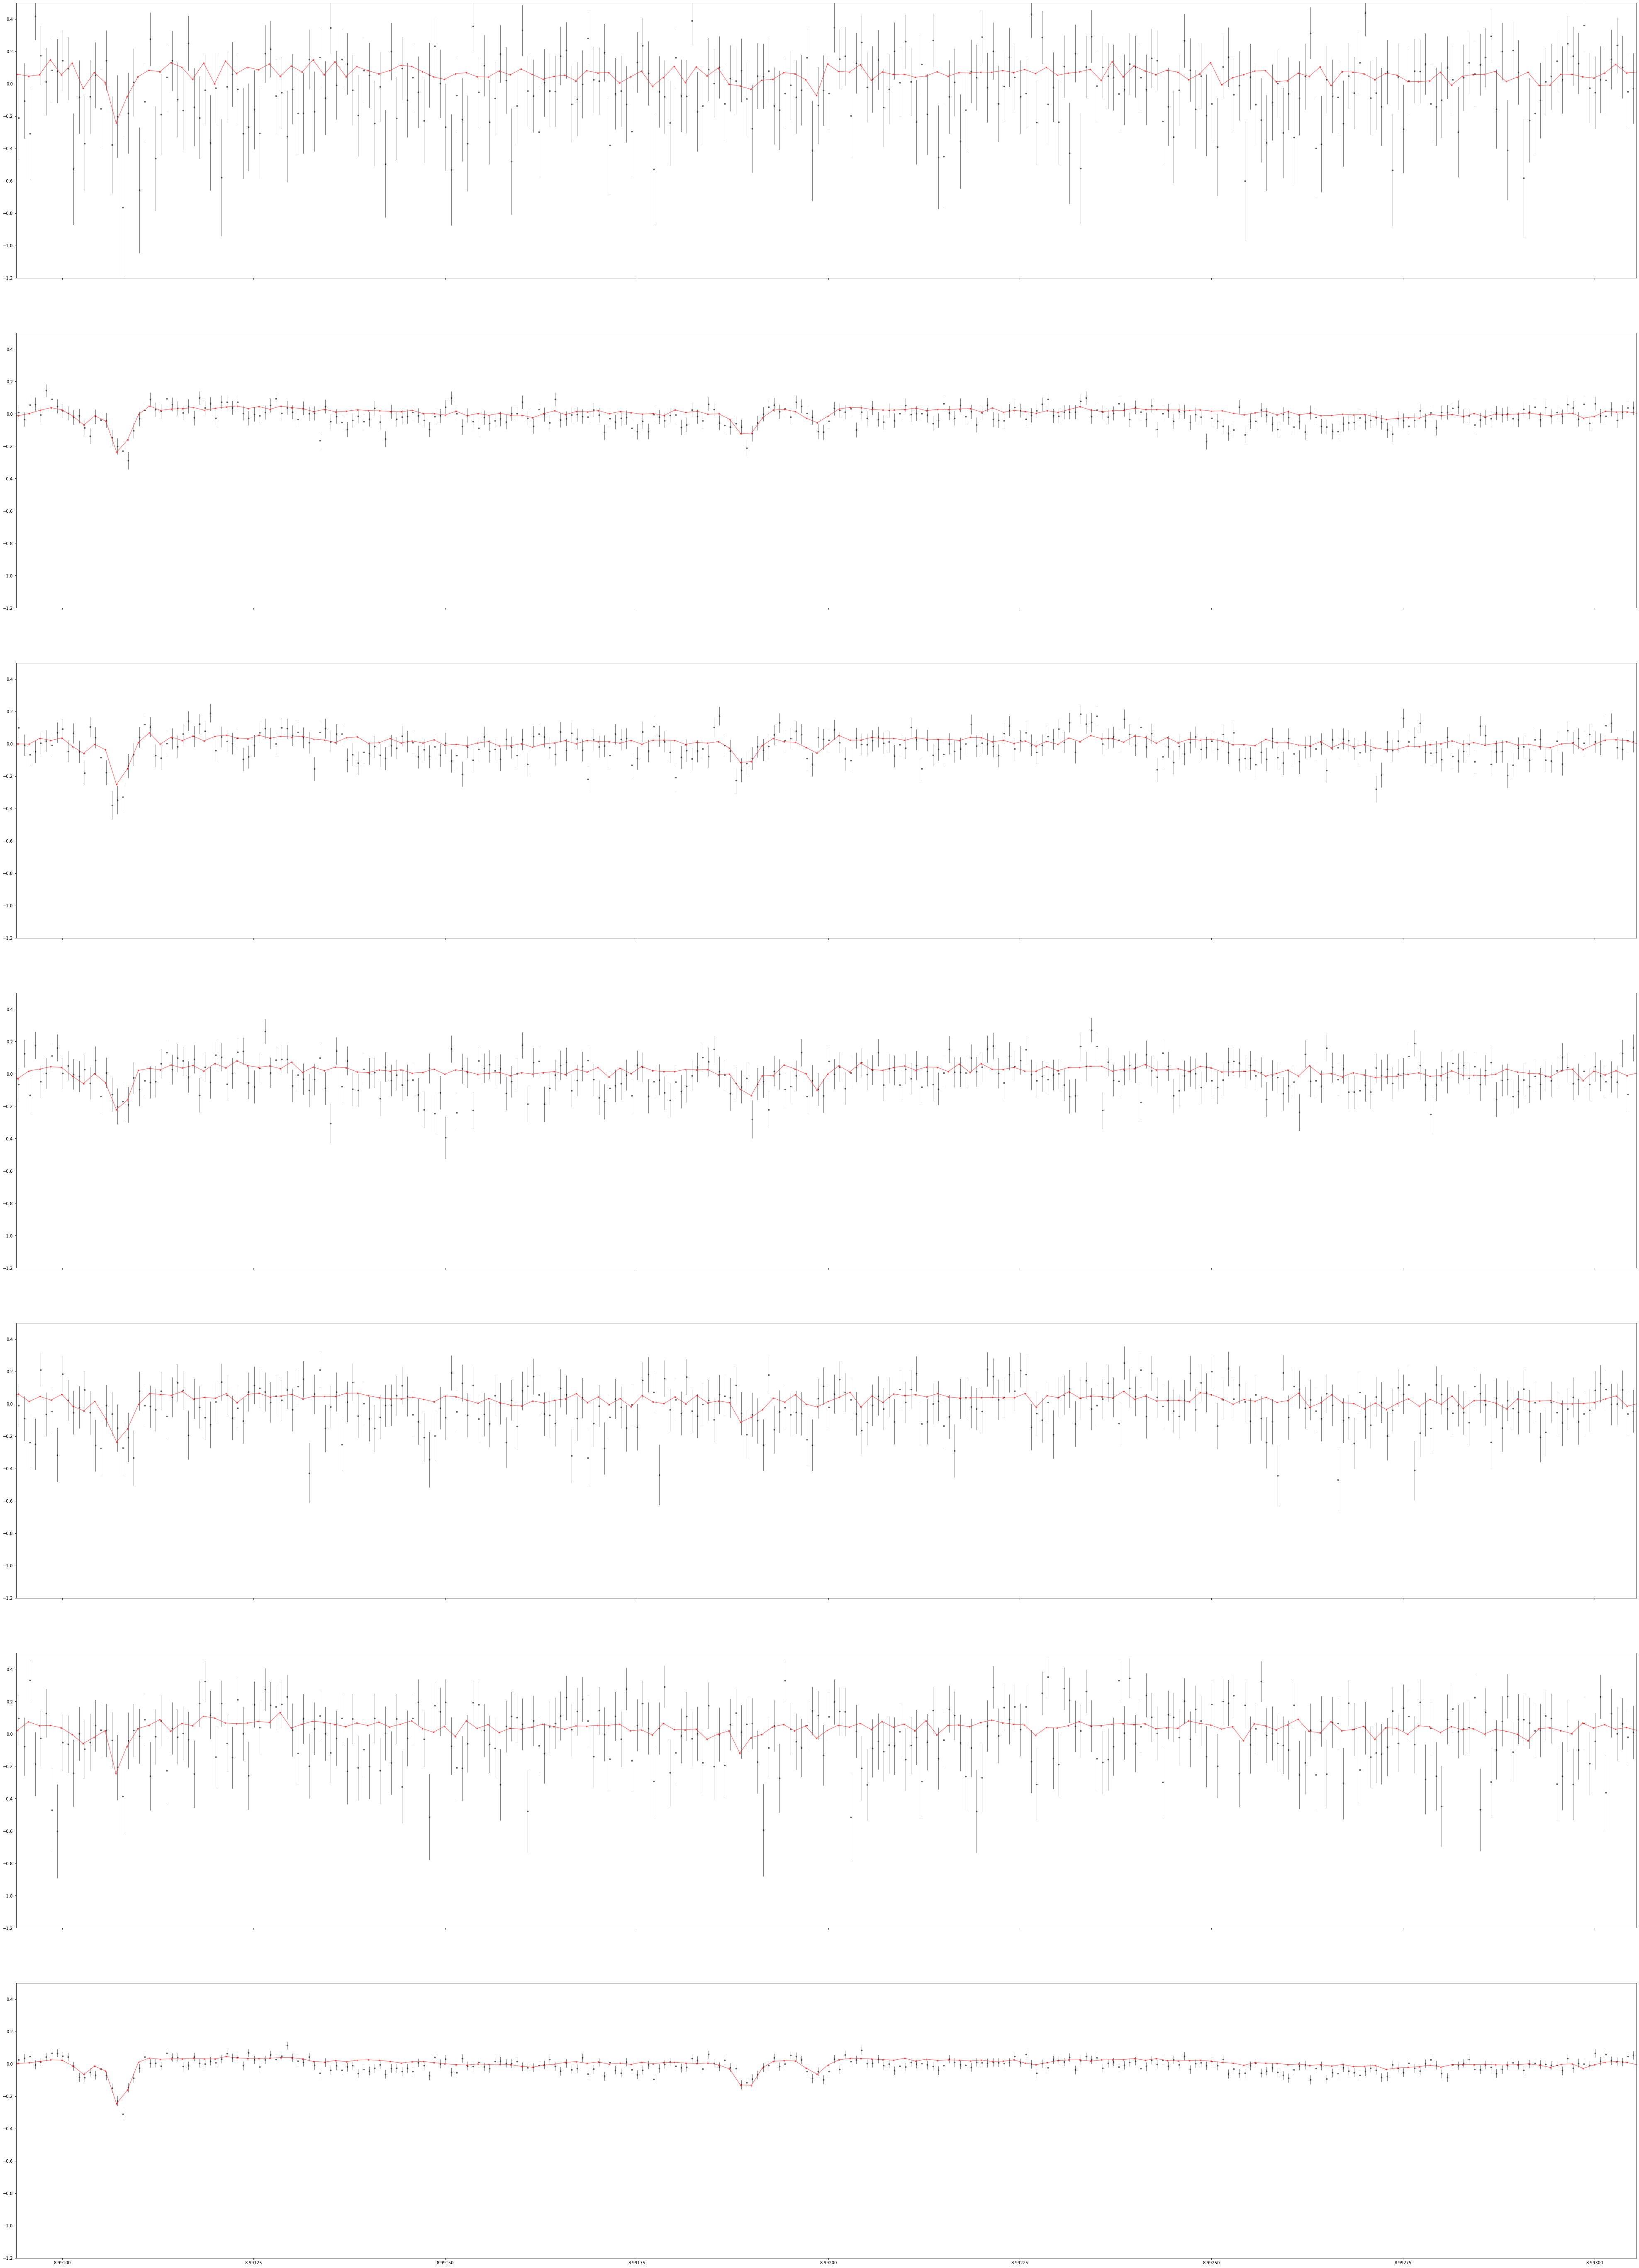

In [22]:
sigma = 80
xpmin = np.log(8030)
xpmax = np.log(8047)
plt_unit = u.Angstrom
plt_epoch = 1
fig, axes = plt.subplots(len(datasets),plt_epoch,figsize=(10 * len(datasets),100 * plt_epoch),sharex=True,sharey=True)
for i in range(len(datasets)):
    for j in range(plt_epoch):
#         datasets[i].plot_star(axes[i,j],j,xy='xy',units=plt_unit,normalize=normalize_2,nargs=[sigma])
#     data.plot_tellurics(axes[i],i,xy='xy',units=plt_unit)
    
        axes[i].errorbar(datasets[i].xs[j,:],datasets[i].ys[j,:],datasets[i].yerr[j,:],fmt='.k',elinewidth=1.1,zorder=1,alpha=0.5,ms=6)
        axes[i].plot(models[i][1].xs-models[i][0].p[j],models[i][1].p,'.r',linestyle='solid',linewidth=1.4,zorder=2,alpha=0.5,ms=6)
        axes[i].set_xlim(xpmin,xpmax)
        axes[i].set_ylim(-1.2,0.5)
plt.show()

In [23]:
print(snrs)
from matplotlib import cm

[4.256094781250072, 20.673860556041475, 13.6178213512239, 9.581021396745623, 7.067424533314906, 5.405074728733711, 34.95785368119855]


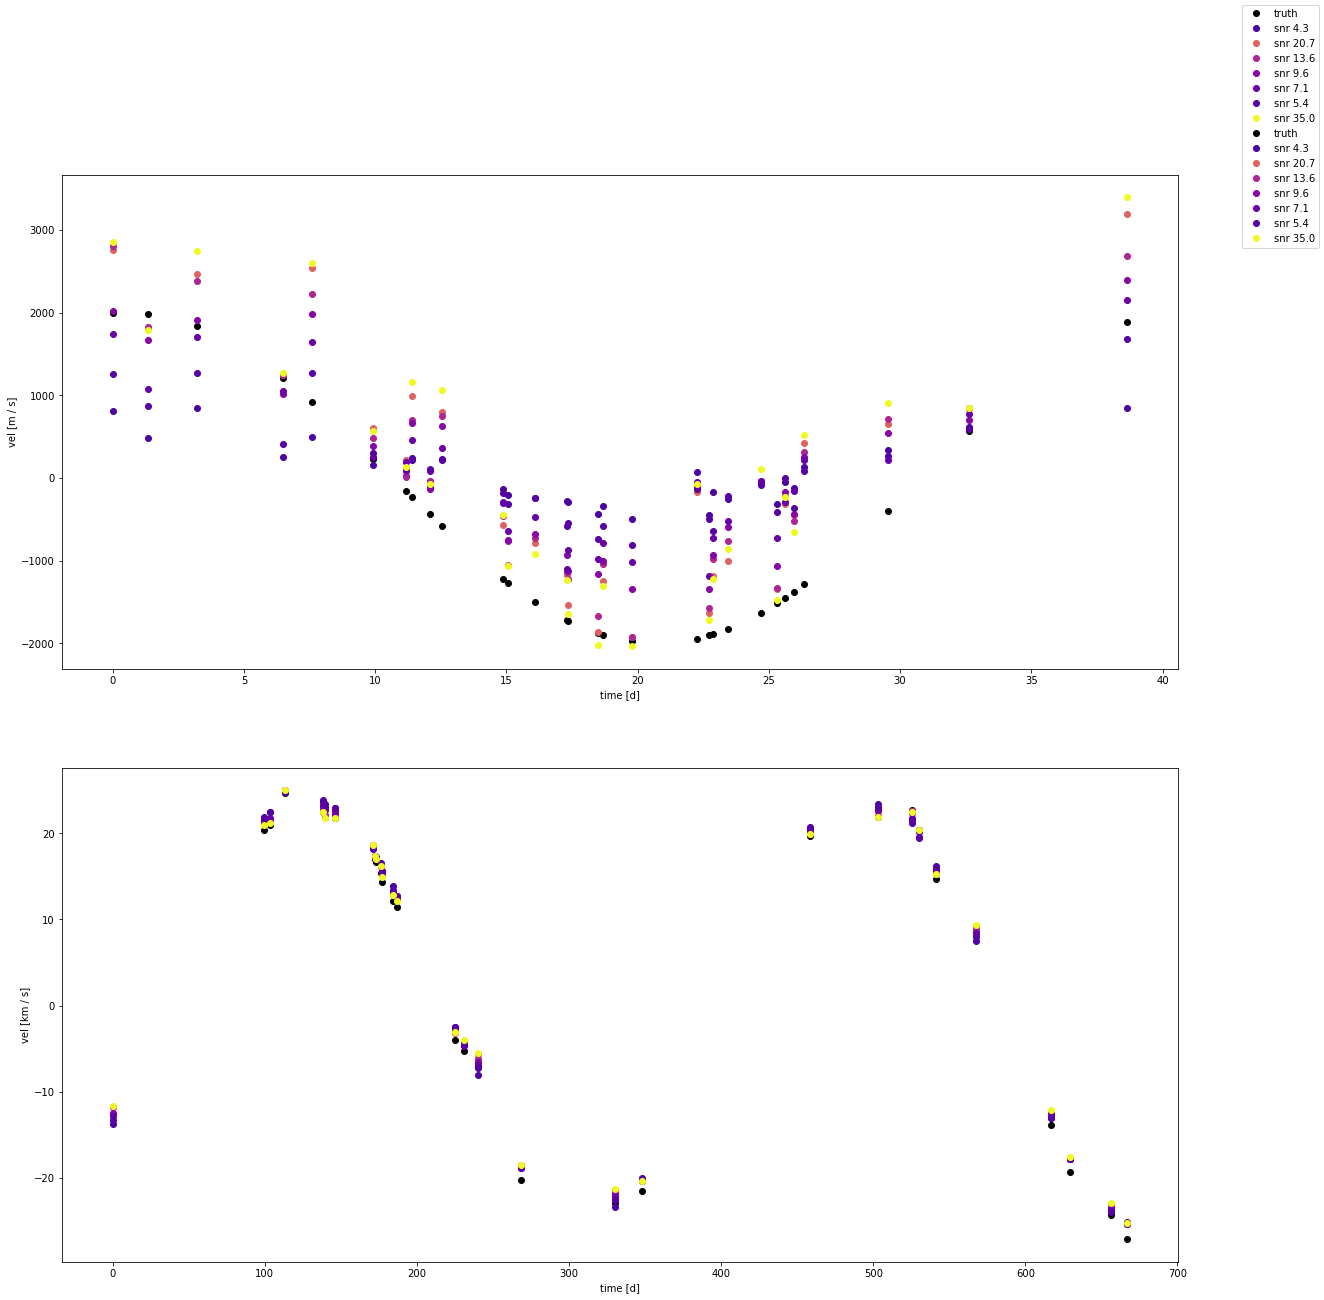

In [30]:
fig, axes = plt.subplots(2,figsize=(20,20))
v_unit = u.m/u.s
axes[0].plot((timess[0] - min(timess[0])).to(u.day).value % periods[0].value,(rvs[0]-bcs[0]).to(v_unit).value,'ok',label='truth')
v_unit = u.km/u.s
axes[1].plot((timess[0] - min(timess[0])).to(u.day).value,(rvs[0]).to(v_unit).value,'ok',label='truth')

# fig.colorbar(cm.plasma)
for i in range(len(datasets)):
    final_vels = jabble.dataset.velocities(models[i][0].p)
    
    v_unit = u.m/u.s
    axes[0].plot((timess[i] - min(timess[i])).to(u.day).value % periods[i].value,(final_vels-bcs[i]).to(v_unit).value,'o',label='snr {:2.1f}'.format(snrs[i]),c=cm.plasma(snrs[i]/max(snrs)))
#     axes[0].set_legend()
    axes[0].set_ylabel('vel [{}]'.format(v_unit))
    axes[0].set_xlabel('time [d]')

    v_unit = u.km/u.s
    axes[1].plot((timess[i] - min(timess[i])).to(u.day).value,(final_vels).to(v_unit).value,'o',label='snr {:2.1f}'.format(snrs[i]),color=cm.plasma(snrs[i]/max(snrs)))
#     axes[1].set_legend()
    axes[1].set_ylabel('vel [{}]'.format(v_unit))
    axes[1].set_xlabel('time [d]')

fig.legend()
plt.savefig('../out/velocity_plots.png')
plt.show()